<div id="haut2page" style="border:3px solid black; padding:3%; font-size:314% ; text-align:center; color:white; background-color:black;">
    SAE 401
</div>

In [435]:
from pandas import*
import geopandas as gpd
from numpy import*
from matplotlib.pyplot import*
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import plotly.express as px
import statsmodels.api as sm
import seaborn as sns
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

# Importation et présentation des données

In [383]:
## Importation de la donnée
Data = read_excel("FichierAnonyme.xlsx")
Data.head()

,ID,Groupe candidat - Code,Classement,Aménagement,Sexe,Candidat boursier - Libellé,Année Scolaire - Libellé 2022/2023,Type de Scolarité - Libellé 2022/2023,Niveau Etude - Libellé 2022/2023,Type Formation - Libellé 2022/2023,...,Note de l'épreuve.32,Epreuve - Libelle.33,Note de l'épreuve.33,Epreuve - Libelle.34,Note de l'épreuve.34,Epreuve - Libelle.35,Note de l'épreuve.35,Date sélection vœu,Date confirmation vœu,Vœu confirmé - Libellé
0,1,150235,ECF,NaN,Masculin,Non boursier,2022-2023,Scolarité française,Terminale,Terminale,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-09 22:43:00,2023-04-05 21:52:00,Validée
1,2,150235,ECF,NaN,Masculin,Non boursier,2022-2023,Scolarité française,Terminale,Terminale,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-05 15:33:00,2023-04-05 16:37:00,Validée
2,3,150236,ECF,NaN,Masculin,Non boursier,2022-2023,Scolarité française,Terminale,Terminale,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-06 19:09:00,2023-04-04 22:52:00,Validée
3,4,150235,ECF,NaN,Masculin,Non boursier,2022-2023,Scolarité française,Terminale,Terminale,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-05 22:52:00,2023-04-06 19:40:00,Validée
4,5,150236,ECF,NaN,Féminin,Boursier de l'enseignement scolaire,2022-2023,Scolarité française,Terminale,Terminale,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-09 21:35:00,2023-04-04 15:05:00,Validée


# Analyse exploratoire des données

<strong style="font-size:1.414em;color:green;">Séléction des données</strong>

<h4 style="color:red;">Vœux confirmés - Vœux non confirmés</h4>
Dans la suite, les analyses se feront sur les candidats qui ont confirmé leur voeux 

In [85]:
Validée=Data.query('`Vœu confirmé - Libellé`=="Validée"')
Non_validée=Data.query('`Vœu confirmé - Libellé`=="Non validée"')

In [201]:
# Créer un dataframe avec le nombre de Vœux confirmés et non confirmés
nb_confirmés = len(Validée['ID'])
nb_non_confirmés = len(Non_validée['ID'])
df_voeux = pd.DataFrame({'Statut': ['Vœu confirmé', 'Vœu Non confirmé'],
                   'Nombre': [nb_confirmés, nb_non_confirmés]})
fig_voeux = px.pie(df_voeux, values='Nombre', names='Statut', title='Proportion de candidature validée/non validée')

<h4 style="color:red;">Boursier - Non Boursier</h4>

In [11]:
Boursier=Validée.query('`Candidat boursier - Libellé`!="Non boursier"')
Non_Boursier=Validée.query('`Candidat boursier - Libellé`=="Non boursier"')

In [207]:
# Créer un dataframe avec le nombre de boursiers et non boursiers
nb_boursiers = len(Boursier['ID'])
nb_non_boursiers = len(Non_Boursier['ID'])
df_bourse = pd.DataFrame({'Statut': ['Boursier', 'Non boursier'],
                   'Nombre': [nb_boursiers, nb_non_boursiers]})
fig_bourse = px.pie(df_bourse, values='Nombre', names='Statut', title='Taux de boursier/non boursier', color='Statut',color_discrete_map={'Boursier':'lightcyan','Non boursier':'cyan'})

<h4 style="color:red;">Hommes - Femmes</h4>

In [123]:
Homme=Validée.query('`Sexe`=="Masculin"')
Femme=Validée.query('`Sexe`=="Féminin"')

In [213]:
# Créer un dataframe avec le nombre de femme et d'homme
nb_femme = len(Femme['ID'])
nb_homme = len(Homme['ID'])
df_sex = pd.DataFrame({'Sexe': ['Homme', 'Femme'],
                   'Nombre': [nb_homme, nb_femme]})
fig_sex = px.pie(df_sex, values='Nombre', names='Sexe', title='Proportion homme/femme',color='Sexe',color_discrete_map={'Homme':'royalblue','Femme':'darkblue'})

<h4 style="color:red;">Nouveaux Bachelier - Ancien Bachelier</h4>
Les nouveaux bacheliers sont les lycéens en terminale pour  l'année academique 2022/2023 et les anciens bacheliers ceux qui ont déja eu le baccalaureat. Pour la suite de l'analyse j'ai choisi de séparer les deux groupes; les nouveaux bacheliers d'un côté et les anciens de l'autre.

In [13]:
Nouveau_Bachelier=Validée.query('` Niveau Etude - Libellé 2022/2023`=="Terminale"')
Ancien_Bachelier=Validée.query('` Niveau Etude - Libellé 2022/2023`!="Terminale"')

In [215]:
# Créer un dataframe avec le nombre de nouveau et ancien bachelier
nb_nouveau = len(Nouveau_Bachelier['ID'])
nb_ancien = len(Ancien_Bachelier['ID'])
df_bach = pd.DataFrame({'Statut': ['Nouveau Bachelier', 'Ancien Bachelier'],
                   'Nombre': [nb_nouveau, nb_ancien]})
fig_bach = px.pie(df_bach, values='Nombre', names='Statut', title='Proportion nouveau/ancien bachelier', color='Statut',color_discrete_map={'Nouveau Bachelier':'lightgreen','Ancien Bachelier':'mediumturquoise'})

<h4 style="color:red;">Nouveaux Bachelier ( Bac généraux - Bac technologique )</h4>

In [15]:
Bac_généraux=Nouveau_Bachelier.query('`Série de classe - Libellé 2022/2023`=="Série Générale"')
Bac_techno=Nouveau_Bachelier.query('`Série de classe - Libellé 2022/2023`!="Série Générale"')

In [217]:
# Créer un dataframe avec le nombre de Bac généraux et Bac technologique
nb_généraux = len(Bac_généraux['ID'])
nb_technologique = len(Bac_techno['ID'])
df_filière = pd.DataFrame({'Filière': ['Bac généraux', 'Bac technologique'],
                   'Nombre': [nb_généraux, nb_technologique]})
fig_filière = px.pie(df_filière, values='Nombre', names='Filière', title='Proportion Bac généraux et Bac technologique',color='Filière',color_discrete_map={'Bac généraux':'gold','Bac technologique':'darkorange'})

<h4 style="color:red;">Répartition des candidats suivant le département de leur lycée d'origine</h4>
J'ai pris ici les départements dont le nombre de candidature est supérieur ou égale à 5

In [196]:
# Créer un dataframe avec le nombre de candidature par département de lycée d'origine
candidats_par_departement = Nouveau_Bachelier.groupby("Commune Etablissement origine - CodePostal 2022/2023")["ID"].count()
df_dep = pd.DataFrame({'Code Département': list(candidats_par_departement.index),
                   'Nombre de candidature': candidats_par_departement.values})
df_dep_1=df_dep.query('`Nombre de candidature`>=5')
fig_dep = px.pie(df_dep_1, values='Nombre de candidature', names='Code Département', title='Répartition des candidats par département pour les nouveaux bacheliers')


<h4 style="color:red;">Répartition des candidats suivant leur lycée d'origine</h4>
J'ai pris ici les lycées dont le nombre de candidature est supérieur ou égale à 5

In [195]:
# Créer un dataframe avec le nombre de candidature par lycée d'origine
candidats_par_etablissement = Nouveau_Bachelier.groupby("Nom Etablissement origine 2022/2023")["ID"].count()
df_etab = pd.DataFrame({'Nom Etablissement': list(candidats_par_etablissement.index),
                   'Nombre de candidature': candidats_par_etablissement.values})
df_etab_1=df_etab.query('`Nombre de candidature`>=5')
fig_etab = px.pie(df_etab_1, values='Nombre de candidature', names='Nom Etablissement', title='Répartition des candidats par Etablissement pour les nouveaux bacheliers')


#### <strong style="font-size:1.414em;color:green;">Visualisation des données</strong>

In [220]:
# Créer les sorties pour chaque onglet
out1 = widgets.Output()
out2 = widgets.Output()
out3 = widgets.Output()
out4 = widgets.Output()
out5 = widgets.Output()
out6 = widgets.Output()
out7 = widgets.Output()

## Créer les graphiques pour chaque sortie
with out1:
    # Afficher le graphique ici
    display(fig_voeux)
# Fonction pour afficher le graphique automatiquement
def display_graph():
    with out1:
        # Afficher le graphique ici
        display(fig_voeux)

with out2:
    # Afficher le graphique ici
    display(fig_bourse)
# Fonction pour afficher le graphique automatiquement
def display_graph():
    with out2:
        # Afficher le graphique ici
        display(fig_bourse)

with out3:
    # Afficher le graphique ici
    display(fig_sex)
# Fonction pour afficher le graphique automatiquement
def display_graph():
    with out3:
        # Afficher le graphique ici
        display(fig_sex)

with out4:
    # Afficher le graphique ici
    display(fig_bach)
# Fonction pour afficher le graphique automatiquement
def display_graph():
    with out4:
        # Afficher le graphique ici
        display(fig_bach)
        
with out5:
    # Afficher le graphique ici
    display(fig_filière)
# Fonction pour afficher le graphique automatiquement
def display_graph():
    with out5:
        # Afficher le graphique ici
        display(fig_filière)
        
with out6:
    # Afficher le graphique ici
    display(fig_dep)
# Fonction pour afficher le graphique automatiquement
def display_graph():
    with out6:
        # Afficher le graphique ici
        display(fig_dep)
        
with out7:
    # Afficher le graphique ici
    display(fig_etab)
# Fonction pour afficher le graphique automatiquement
def display_graph():
    with out7:
        # Afficher le graphique ici
        display(fig_etab)

# Créer un widget Tab pour organiser les onglets
onglets = widgets.Tab()
onglets.children = [out1, out2, out3, out4, out5, out6, out7]
onglets.set_title(0, 'Voeux')
onglets.set_title(1, 'Bourse')
onglets.set_title(2, 'Genre')
onglets.set_title(3, 'Nouveau/Ancien')
onglets.set_title(4, 'Filière')
onglets.set_title(5, 'Département')
onglets.set_title(6, 'Etablissement')

# Créer un widget Accordion pour organiser les onglets en panneaux pliables
panneaux = widgets.Accordion(children=[onglets])
panneaux.set_title(0, 'Graphiques')

# Afficher le widget Accordion
display(panneaux)

Accordion(children=(Tab(children=(Output(), Output(), Output(), Output(), Output(), Output(), Output()), selec…

# Analyse de régression

<strong style="font-size:1.414em;color:green;">Candidats du  Baccalauréat filière générale</strong>

J'ai pris ici, pour l'analyse la 'Moyenne du Candidat en Langue vivante A pour trimestre 1', la 'Moyenne du Candidat en Langue vivante B pour trimestre 1', la 'Moyenne du Candidat en Enseignement scientifique pour trimestre 1' et la 'Moyenne du Candidat en Mathématiques Spécialité pour trimestre 1'. Je supprime les lignes pour lesquelles les notes n'exixtent pas ou sont manquantes et je fais ensuite par rapport à la colonne ID une jointure.

<h4 style="color:red;">Récupération de la data et nettoyage</h4>

In [ ]:

df_notes_LVA=Bac_généraux.loc[:,['ID',"Moyenne du Candidat en Langue vivante A pour trimestre 1"]]
df_notes_LVA["Moyenne du Candidat en Langue vivante A pour trimestre 1"] = df_notes_LVA["Moyenne du Candidat en Langue vivante A pour trimestre 1"].replace('Aucune note', np.nan)
df_notes_LVA = df_notes_LVA.dropna(subset=['Moyenne du Candidat en Langue vivante A pour trimestre 1'])

df_notes_LVB=Bac_généraux.loc[:,['ID',"Moyenne du Candidat en Langue vivante B pour trimestre 1"]]
df_notes_LVB['Moyenne du Candidat en Langue vivante B pour trimestre 1'] = df_notes_LVB['Moyenne du Candidat en Langue vivante B pour trimestre 1'].replace('Aucune note', np.nan)
df_notes_LVB = df_notes_LVB.dropna(subset=['Moyenne du Candidat en Langue vivante B pour trimestre 1'])

df_notes_ES=Bac_généraux.loc[:,['ID',"Moyenne du Candidat en Enseignement scientifique pour trimestre 1"]]
df_notes_ES["Moyenne du Candidat en Enseignement scientifique pour trimestre 1"] = df_notes_ES["Moyenne du Candidat en Enseignement scientifique pour trimestre 1"].replace('Aucune note', np.nan)
df_notes_ES = df_notes_ES.dropna(subset=["Moyenne du Candidat en Enseignement scientifique pour trimestre 1"])

df_notes_MS=Bac_généraux.loc[:,['ID',"Moyenne du Candidat en Mathématiques Spécialité pour trimestre 1"]]
df_notes_MS["Moyenne du Candidat en Mathématiques Spécialité pour trimestre 1"] = df_notes_MS["Moyenne du Candidat en Mathématiques Spécialité pour trimestre 1"].replace('Aucune note', np.nan)
df_notes_MS = df_notes_MS.dropna(subset=["Moyenne du Candidat en Mathématiques Spécialité pour trimestre 1"])


<h4 style="color:red;">Jointures</h4>

In [293]:
# Joindre les deux premiers dataframes par rapport à la colonne ID
df_merge1 = pd.merge(df_notes_LVA, df_notes_LVB, on='ID')

# Joindre le troisième dataframe au résultat de la première jointure
df_merge2 = pd.merge(df_merge1, df_notes_ES, on='ID')

# Joindre le quatrième dataframe au résultat de la deuxième jointure
df_final_BG = pd.merge(df_merge2, df_notes_MS, on='ID')
df_final_BG

,ID,Moyenne du Candidat en Langue vivante A pour trimestre 1,Moyenne du Candidat en Langue vivante B pour trimestre 1,Moyenne du Candidat en Enseignement scientifique pour trimestre 1,Moyenne du Candidat en Mathématiques Spécialité pour trimestre 1
0,1,16.50,15.00,13.11,8.63
1,4,16.14,13.38,15.83,12.07
2,6,12.00,14.67,12.13,11.26
3,8,15.00,15.00,16.00,13.90
4,9,14.00,14.50,9.50,13.00
...,...,...,...,...,...
383,644,13.33,12.40,11.32,17.08
384,645,19.72,14.16,14.40,13.33
385,647,14.00,11.85,13.76,13.07
386,648,15.14,13.88,12.50,8.00


<h4 style="color:red;">(Langue vivante A) VS (Langue vivante B)</h4>

In [376]:

# Données 
X = df_final_BG['Moyenne du Candidat en Langue vivante A pour trimestre 1']
y = df_final_BG['Moyenne du Candidat en Langue vivante B pour trimestre 1']
X = sm.add_constant(X)

# Ajuster le modèle de régression
model = sm.OLS(y, X).fit()

# Créer une grille de sous-graphiques
fig1, axs = plt.subplots(1, 2, figsize=(15, 4))

# Dessiner le graphique dans le premier sous-graphique
axs[0].scatter(X["Moyenne du Candidat en Langue vivante A pour trimestre 1"], y)
axs[0].plot(X["Moyenne du Candidat en Langue vivante A pour trimestre 1"], model.predict(), color="red")
axs[0].set_xlabel("Langue vivante A")
axs[0].set_ylabel("Langue vivante B")

# Afficher les résultats de la régression dans le deuxième sous-graphique
table_data = [    ["Coefficient", "Std. Error", "t-value", "p-value"],
    ["Intercept", round(model.params[0], 3), round(model.bse[0], 3), round(model.tvalues[0], 3)],
    ["Advertising", round(model.params[1], 3), round(model.bse[1], 3), round(model.tvalues[1], 3)],
    ["R-squared", "", "", round(model.rsquared, 3)],
    ["Prob (F-statistic)", round(model.f_pvalue, 3), "", ""]
]

axs[1].axis("off")
axs[1].table(cellText=table_data, colLabels=None, cellLoc="center", loc="center")
plt.close()

<h4 style="color:red;">(Enseignement scientifique) VS (Mathématiques Spécialité)</h4>

In [377]:

# Données 
X = df_final_BG['Moyenne du Candidat en Enseignement scientifique pour trimestre 1']
y = df_final_BG['Moyenne du Candidat en Mathématiques Spécialité pour trimestre 1']
X = sm.add_constant(X)

# Ajuster le modèle de régression
model = sm.OLS(y, X).fit()

# Créer une grille de sous-graphiques
fig2, axs = plt.subplots(1, 2, figsize=(15, 4))

# Dessiner le graphique dans le premier sous-graphique
axs[0].scatter(X["Moyenne du Candidat en Enseignement scientifique pour trimestre 1"], y)
axs[0].plot(X["Moyenne du Candidat en Enseignement scientifique pour trimestre 1"], model.predict(), color="red")
axs[0].set_xlabel("Enseignement scientifique")
axs[0].set_ylabel("Mathématiques Spécialité")

# Afficher les résultats de la régression dans le deuxième sous-graphique
table_data = [    ["Coefficient", "Std. Error", "t-value", "p-value"],
    ["Intercept", round(model.params[0], 3), round(model.bse[0], 3), round(model.tvalues[0], 3)],
    ["Advertising", round(model.params[1], 3), round(model.bse[1], 3), round(model.tvalues[1], 3)],
    ["R-squared", "", "", round(model.rsquared, 3)],
    ["Prob (F-statistic)", round(model.f_pvalue, 3), "", ""]
]

axs[1].axis("off")
axs[1].table(cellText=table_data, colLabels=None, cellLoc="center", loc="center")
plt.close()

<h4 style="color:red;">Régression linéaire</h4>

In [381]:
# Créer les sorties pour chaque onglet
out1 = widgets.Output()
out2 = widgets.Output()

## Créer les graphiques pour chaque sortie
with out1:
    # Afficher le graphique ici
    display(fig1)
# Fonction pour afficher le graphique automatiquement
def display_graph():
    with out1:
        # Afficher le graphique ici
        display(fig1)

with out2:
    # Afficher le graphique ici
    display(fig2)
# Fonction pour afficher le graphique automatiquement
def display_graph():
    with out2:
        # Afficher le graphique ici
        display(fig2)

# Créer un widget Tab pour organiser les onglets
onglets = widgets.Tab()
onglets.children = [out1, out2]
onglets.set_title(0, 'LVA vs LVB')
onglets.set_title(1, 'ES vs MS')

# Créer un widget Accordion pour organiser les onglets en panneaux pliables
panneaux = widgets.Accordion(children=[onglets])
panneaux.set_title(0, 'Régression linéaire')

# Afficher le widget Accordion
display(panneaux)

Accordion(children=(Tab(children=(Output(), Output()), selected_index=0, titles=('LVA vs LVB', 'ES vs MS')),),…

# Analyse de segmentation

<h4 style="color:red;">Dendrograms - Classification ascendante hiérarchique)</h4>
Les arguments p=4, truncate_mode="level"signifient que l'on ne va afficher que les clusters issus de 4 noeuds

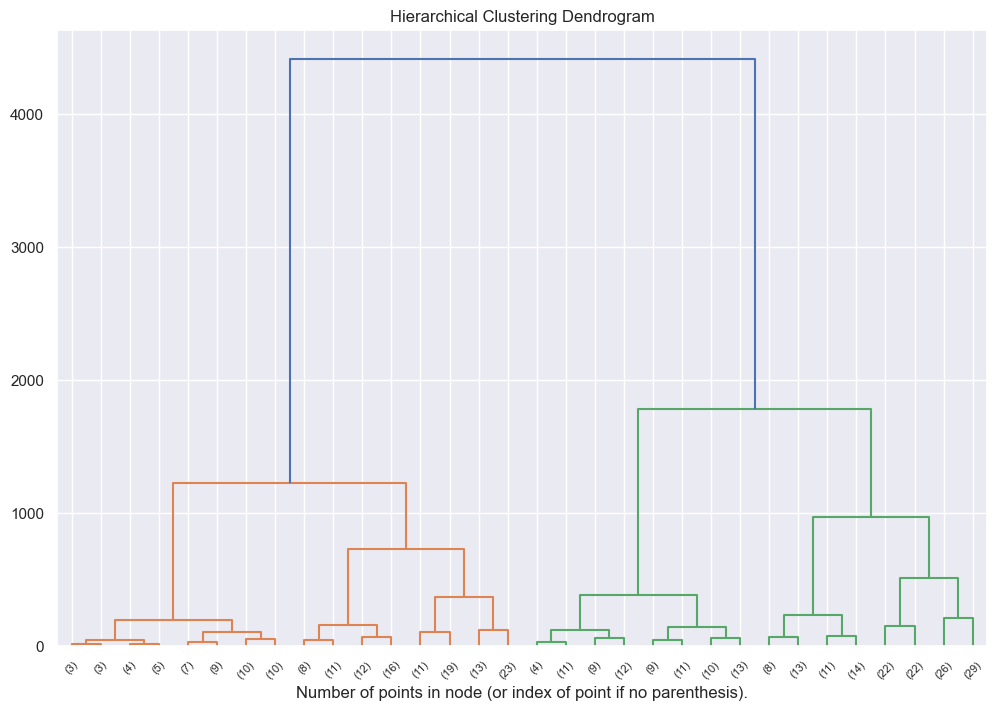

In [439]:
X=df_final_BG.copy()
X.columns = ['ID','LA', 'LB', 'ES', 'MS']
W = linkage(X, method="ward")

fig_1, ax = plt.subplots(1, 1, figsize=(12, 8))

_ = dendrogram(Z, p=4, truncate_mode="level", ax=ax)

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

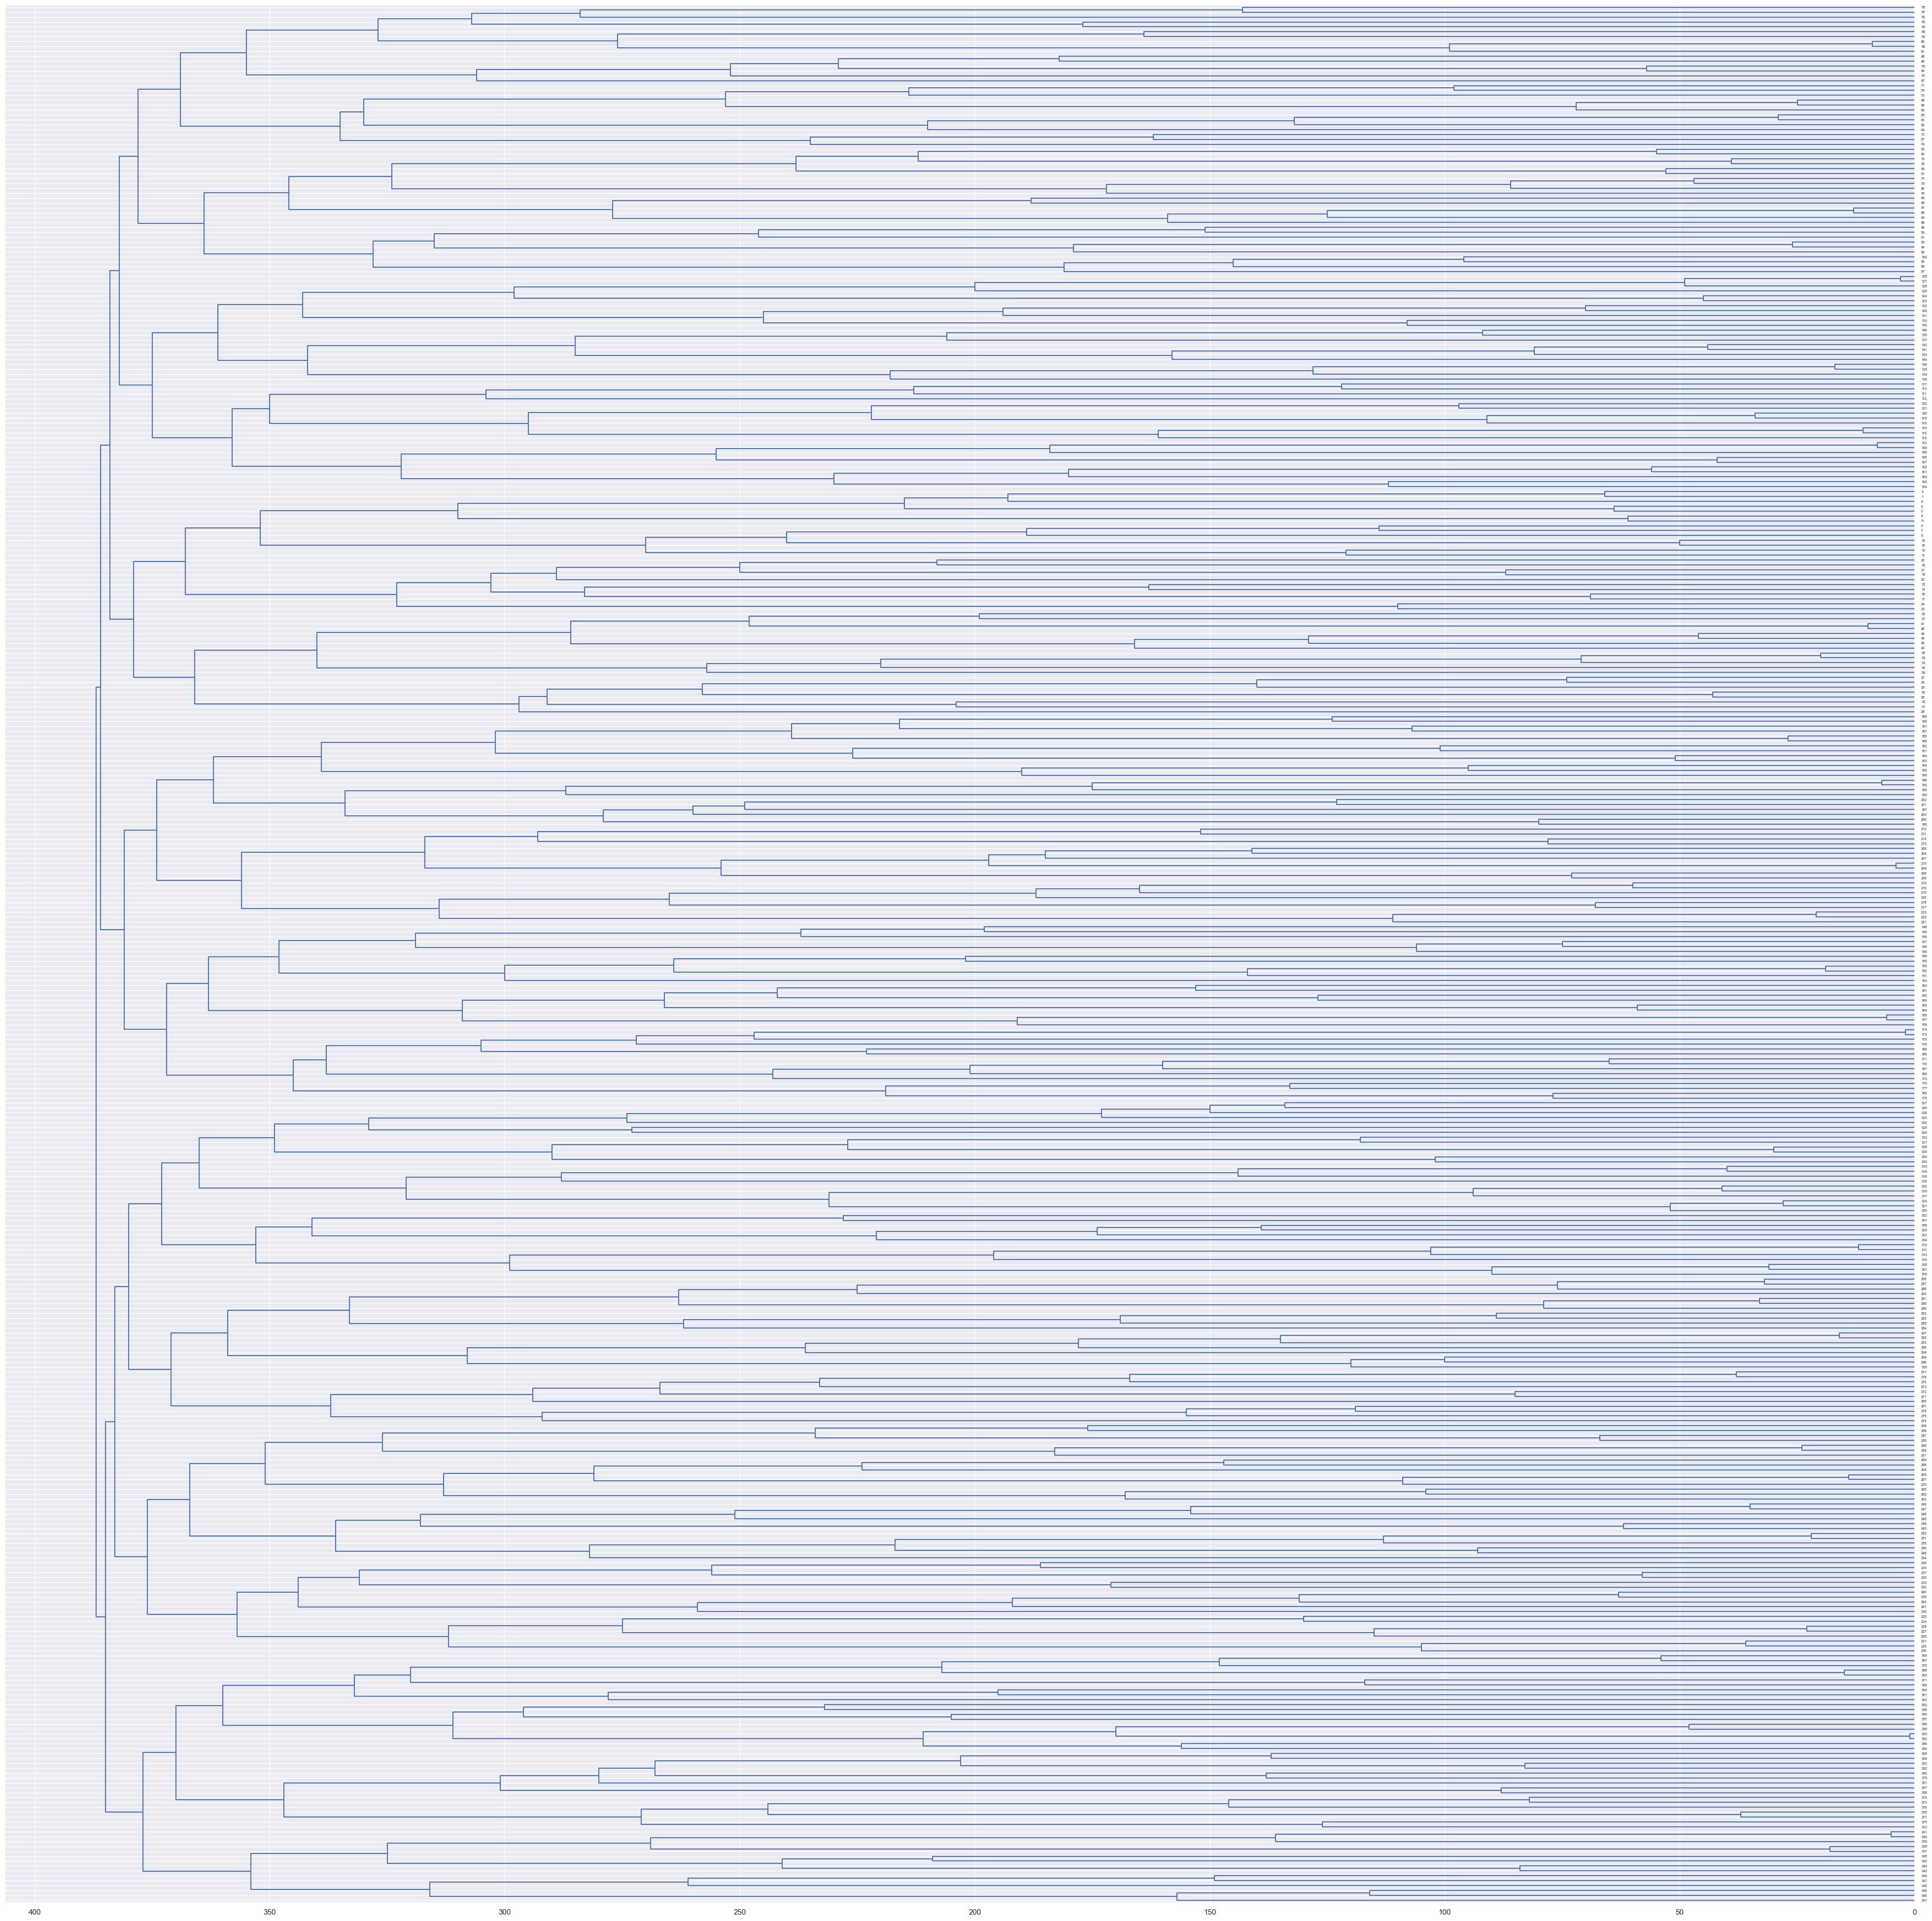

In [434]:

ward = AgglomerativeClustering(linkage='ward', compute_full_tree=True).fit(X)
AgglomerativeClustering(compute_full_tree=True)
dendro = [ ]
for a,b in ward.children_:
    dendro.append([a, b, float(len(dendro)+1), len(dendro)+1])
    # le dernier coefficient devrait contenir le nombre de feuilles dépendant de ce noeud
    # et non le dernier indice
    # de même, le niveau (3ème colonne) ne devrait pas être le nombre de noeud
    # mais la distance de Ward

fig_2 = plt.figure( figsize=(50,50) )
ax = fig_2.add_subplot(1,1,1)
r = dendrogram(dendro, color_threshold=1, labels=list(df_final_BG.index),
               show_leaf_counts=True, ax=ax, orientation="left")

<h4 style="color:red;">Clusters - Matrice de corrélation et dendogramme</h4>

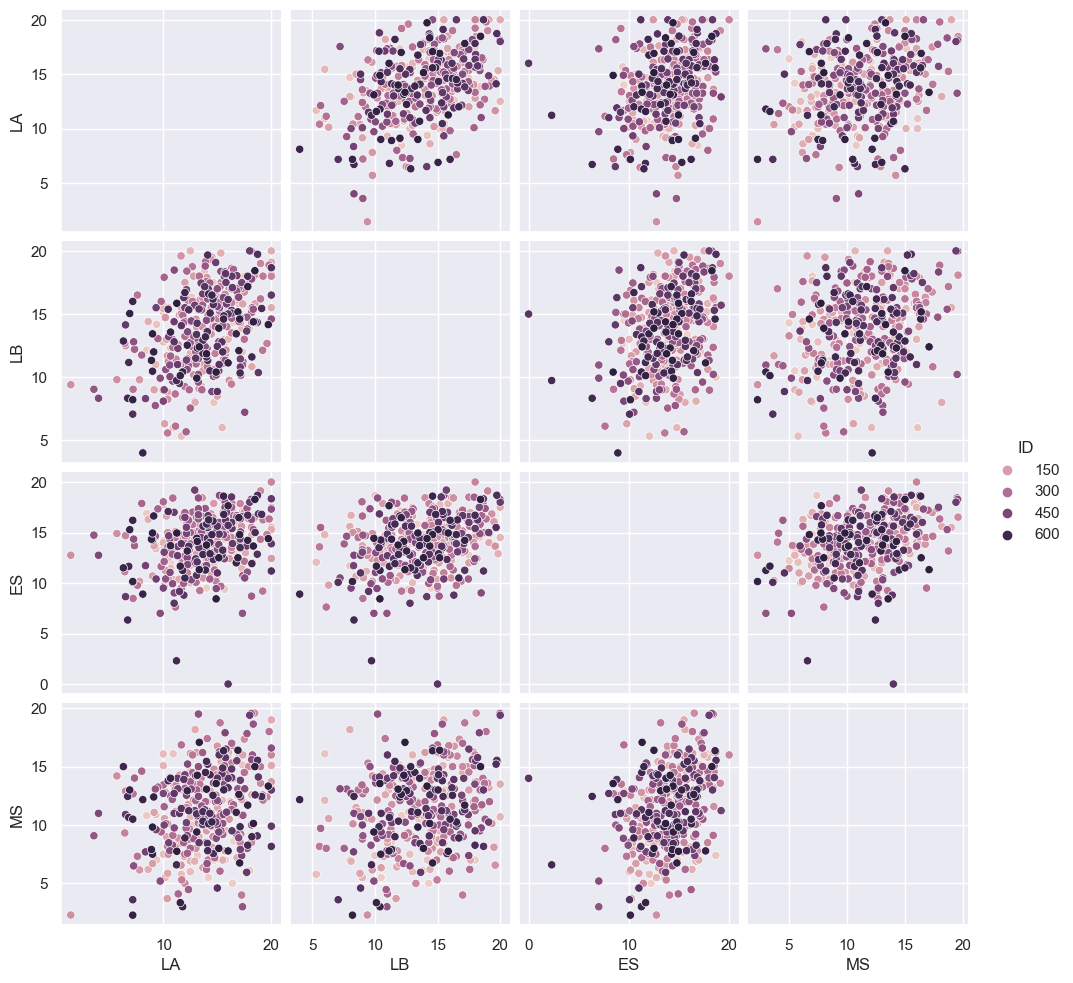

In [ ]:
sns.set()
cah = AgglomerativeClustering(n_clusters=2, linkage="ward")
cah.fit(X)
sns.pairplot(X, hue="ID")

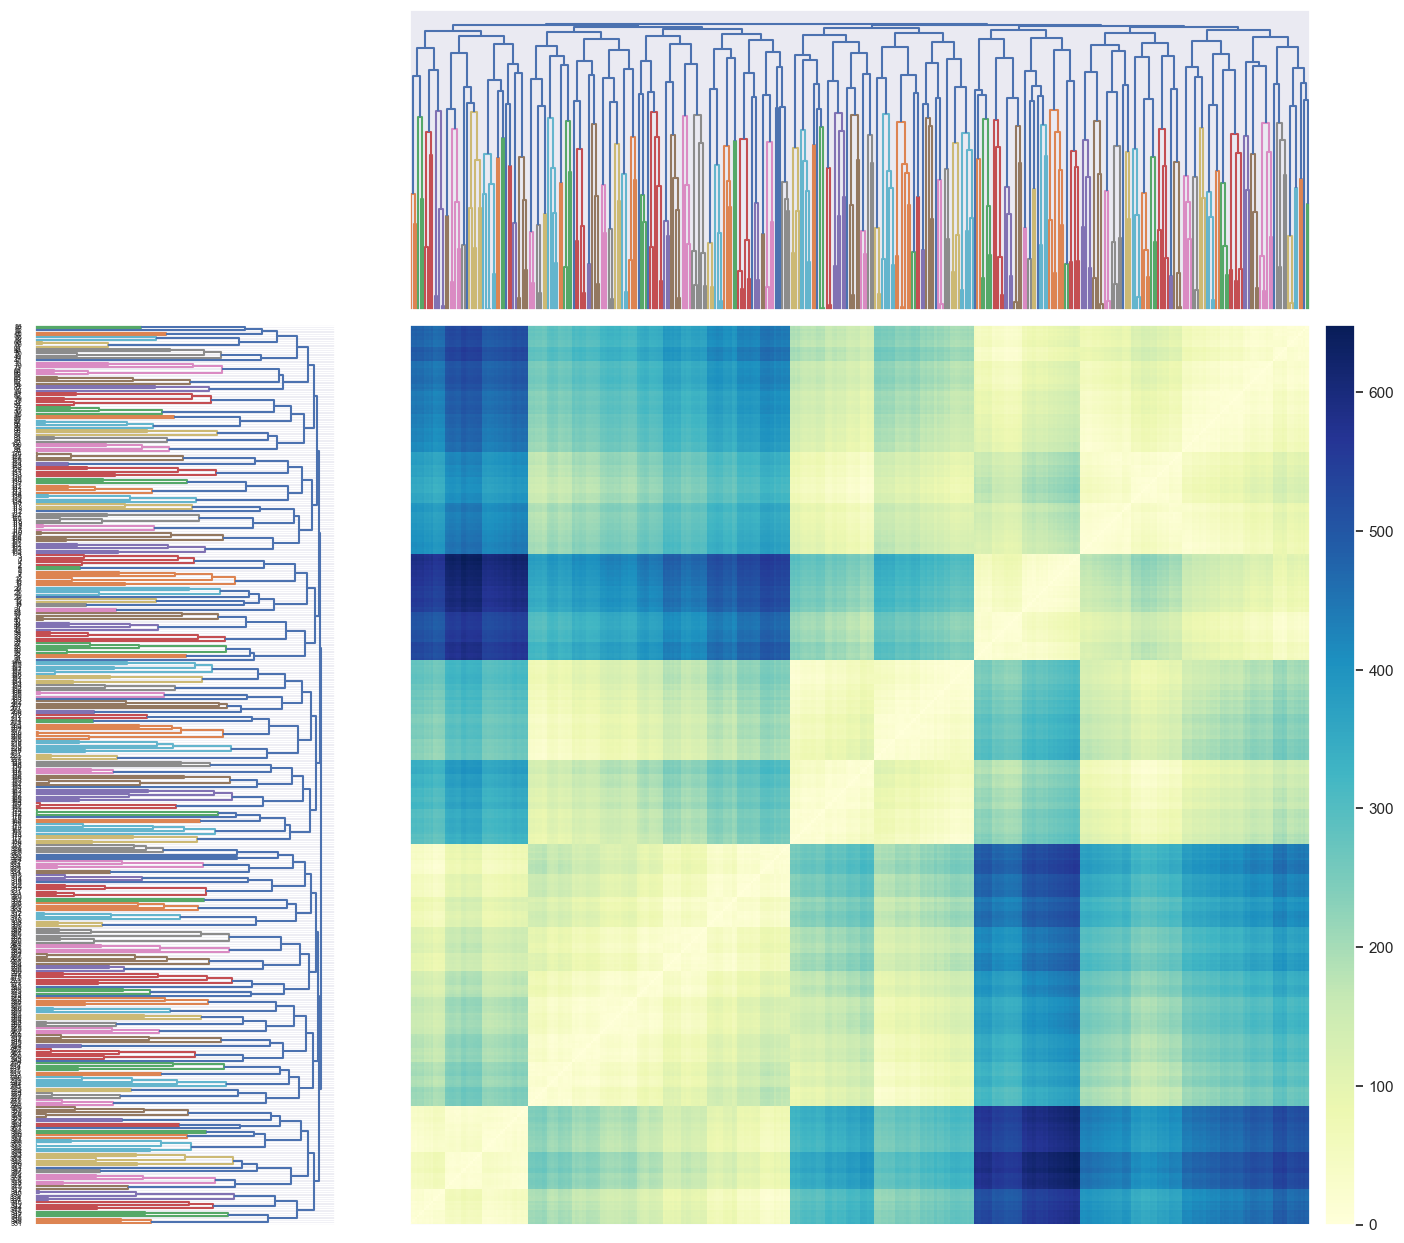

In [433]:

data_dist = pdist(X)

fig = plt.figure(figsize=(15,15))

# x ywidth height
ax1 = fig.add_axes([0.05,0.1,0.2,0.6])
Z1 = dendrogram(dendro, orientation='right',labels=list(X.index))
ax1.set_xticks([])

# Compute and plot second dendrogram.
ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Z2 = dendrogram(dendro)
ax2.set_xticks([])
ax2.set_yticks([])

# Compute and plot the heatmap
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']

D = squareform(data_dist)
D = D[idx1,:]
D = D[:,idx2]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=plt.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
plt.colorbar(im, cax=axcolor)